## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

In [4]:
! git clone https://github.com/jonahcic/PCA

Cloning into 'PCA'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 12), reused 14 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 2.42 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [2]:
df = pd.read_parquet("https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet")
tokens = df["Email Text"].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


In order to clean the tokens I would remove punctuation and commonly used words and phrases. To predict whther an email is a phishing scam or not, I would use a PCA algorithm (since that is this assignment's topic) using the existence of the remaining tokens in emails.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [6]:
with open('/content/PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


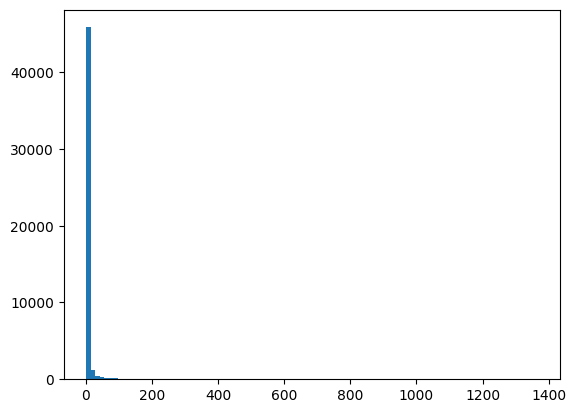

In [7]:
gdf = pd.DataFrame(token_freq,columns=["token","count"])
gdf["count"].hist(grid=False,bins=100)
gdf['count'].describe()

The histogram is extremely right-skewed. This suggests that the vast majority of the tokens only appear a minimal amount of times, while one of the tokens appears 1,365 times.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [10]:
### 1

df = pd.read_parquet("/content/PCA/05_PCA/Phishing_clean.parquet")

y = df["Email Type"]
X = df.drop("Email Type",axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [12]:
### 2

model = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print("Train R-squared: ", r2_score(y_hat_train,y_train) )
print("Test R-squared: ", r2_score(y_hat_test,y_test) )

Train R-squared:  0.6238533338647383
Test R-squared:  -0.0001035630708532409


In [14]:
### 3

coeff = pd.DataFrame({'variable':model.feature_names_in_ , 'value':model.coef_})
coeff['abs'] = np.abs(coeff['value'])
coeff.sort_values('abs',ascending=False)

,variable,value,abs
1573,100%,7.164368e+12,7.164368e+12
1133,"19,",-7.085953e+12,7.085953e+12
421,1995,6.591663e+12,6.591663e+12
864,2nd,6.282716e+12,6.282716e+12
1722,70%,-6.252022e+12,6.252022e+12
...,...,...,...
2109,spending,-8.535385e-05,8.535385e-05
966,makes,4.100800e-05,4.100800e-05
953,stuff,2.384186e-05,2.384186e-05
63,international,-1.525879e-05,1.525879e-05


The words with the largest coefficients in absolute value are in fact numbers (years, percentages, etc.).

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

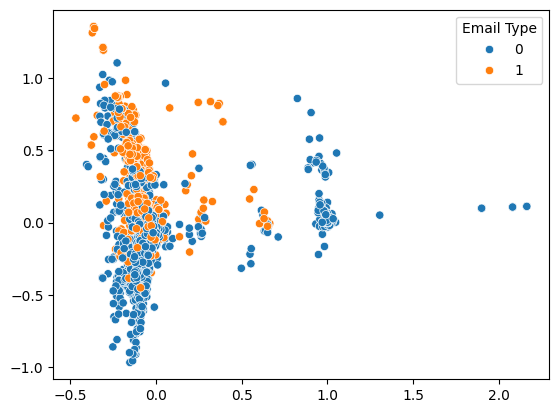

In [15]:
PCA_decomp = PCA(n_components=2).fit(X_train)
Z_train = PCA_decomp.transform(X_train)
Z_test = PCA_decomp.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

From observing the scatter plot, it seems like the scam emails (orange) have a higher and more left average position than the blue dots (real).

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [16]:
pcomp = PCA(n_components=2610).fit(X_train)
Z_train = pcomp.transform(X_train)
Z_test = pcomp.transform(X_test)

model = LinearRegression().fit(Z_train,y_train)
y_hat_test = model.predict(Z_test)
y_hat_train = model.predict(Z_train)

print("Train R-squared: ", r2_score(y_hat_train,y_train))
print("Test R-squared: ", r2_score(y_hat_test,y_test))

Train R-squared:  0.6952988671088505
Test R-squared:  0.5725697929602989


This model's performance is better compared to the standard linear regression from earlier.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

The advantage of using principal components rather than the original data in this high-dimensional regression is that the issue of multi-colinearity is not an issue, due to the reduced dimensionality of principal component decomposition.